# HARDWARE

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
To change attributes:
1) Change ATTRIBUTE and you're good to go
"""
ATTRIBUTE = 'polarity'
COUNTER = 1002
PARALLEL = 30
PARALLEL_EXTRACTION = 8
TRAIN_SIZE = 1000
DEV_SIZE = 125

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')
snorkel_postgres = os.environ['SNORKELDB'].startswith('postgres')
print snorkel_postgres

True


In [2]:
import os
if snorkel_postgres:
    os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER)
    print os.system("dropdb " + os.environ['SNORKELDBNAME'])
    print os.system("createdb " + os.environ['SNORKELDBNAME'])
    print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']
else:
    try:
        os.remove('snorkel.db')
    except:
        pass

from snorkel import SnorkelSession
session = SnorkelSession()

256
0
SNORKELDBNAME = polarity1002


## Parsing

In [3]:
import os
if snorkel_postgres:
    from snorkel.async_parser import parse_corpus, HTMLParser, AsyncOmniParser
    print "Starting async parse..."
    
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_digikey/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_digikey/pdf/'
    doc_parser = HTMLParser()
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Train', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=TRAIN_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Dev', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=DEV_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
else:
    from snorkel.parser import CorpusParser, HTMLParser, OmniParser
    from snorkel.utils import get_ORM_instance
    from snorkel.queries import split_corpus

    print "Starting sync parse..."
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=100)

    %time corpus = cp.parse_corpus(name='Hardware Train', session=session)
    print "%s contains %d documents" % corpus, len(corpus)

    session.add(corpus)
    session.commit()
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                 tabular=True, lingual=True,
                                 visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=125)

    %time corpus = cp.parse_corpus(name='Hardware Dev', session=session)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.add(corpus)
    session.commit()

Starting async parse...
[========================================] 100%
CPU times: user 764 ms, sys: 520 ms, total: 1.28 s
Wall time: 3min 42s
Corpus (Hardware Train) contains 1000 documents
[========================================] 100%
CPU times: user 300 ms, sys: 212 ms, total: 512 ms
Wall time: 55.6 s
Corpus (Hardware Dev) contains 122 documents


### Save Corpus

In [4]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [5]:
# # If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ corpus snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

In [6]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Define Matchers

In [8]:
from hardware_matchers import get_matcher

part_matcher = get_matcher('part')
attr_matcher = get_matcher(ATTRIBUTE)

### Define ContextSpaces

In [9]:
from hardware_spaces import get_space
    
part_ngrams = get_space('part')
attr_ngrams = get_space(ATTRIBUTE)

### Define Candidate Throttler

In [10]:
from hardware_throttlers import get_throttler

throttler = get_throttler(ATTRIBUTE)
# throttler = None

### Run CandidateExtractor

In [11]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
from snorkel.async_candidates import parallel_extract

ce = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)


for corpus_name in ['Hardware Train', 'Hardware Dev']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = parallel_extract(session, ce, corpus, \
                                        corpus_name + ' Candidates', \
                                        parallel=PARALLEL_EXTRACTION)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Train)
[========================================] 100%
CPU times: user 128 ms, sys: 192 ms, total: 320 ms
Wall time: 36min 32s
Candidate Set (Hardware Train Candidates) contains 67083 Candidates
Extracting Candidates from Corpus (Hardware Dev)
[========================================] 100%
CPU times: user 44 ms, sys: 88 ms, total: 132 ms
Wall time: 14min 47s
Candidate Set (Hardware Dev Candidates) contains 19846 Candidates


### Second Pass

In [12]:
# from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
# from snorkel.utils import get_ORM_instance
# from snorkel.models import Corpus

# corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')

# # parts_by_doc = get_gold_parts_by_doc()
# parts_by_doc = get_manual_parts_by_doc(corpus.documents)
# # parts_by_doc = None

In [13]:
# import cPickle as pickle
# pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc.pkl'

# with open(pickle_file, 'w') as f:
#     pickle.dump(parts_by_doc, f)

In [14]:
import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

### Assess Recall

In [15]:
from snorkel.models import Corpus, CandidateSet
from hardware_utils import entity_level_f1_from_candidates

corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')
candidates = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
gold_file = os.environ['SNORKELHOME'] + \
    '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
(ctp, cfp, cfn) = entity_level_f1_from_candidates(candidates, gold_file, ATTRIBUTE, \
                                                  corpus=corpus, relation=False, \
                                                  parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.843
Corpus Recall    0.901
Corpus F1        0.871
----------------------------------------
TP: 835 | FP: 156 | FN: 92



In [16]:
from pprint import pprint
pprint(cfp)

[(u'BC337', u'BC33716'),
 (u'BC337', u'BC33725'),
 (u'BC337', u'BC33740'),
 (u'BC337', u'BC33740BU'),
 (u'BC337', u'BC338-16'),
 (u'BC337', u'BC338-40'),
 (u'BC337', u'BC33825'),
 (u'BC337-D', u'BC337-XX'),
 (u'BC546', u'BC548A'),
 (u'BC546', u'BC549A'),
 (u'BC546', u'BC550A'),
 (u'BC546', u'BC550B'),
 (u'BC546-BC548C(TO-92)', u'BC546-BC548C'),
 (u'BC546_DIOTEC', u'BC546C'),
 (u'BC546_DIOTEC', u'BC549A'),
 (u'BC547', u'BC548A'),
 (u'BC547', u'BC548BU'),
 (u'BC547', u'BC549A'),
 (u'BC547', u'BC550A'),
 (u'BC547', u'BC550B'),
 (u'BC818-40LT1-D', u'BC818-40LT1'),
 (u'CSEMS05382-1', u'BC546-48ABC'),
 (u'DIODESINCORPORATED_FCX491ATA', u'AP02001'),
 (u'DIODESINCORPORATED_FCX491ATA', u'AP02002'),
 (u'DIODESINCORPORATED_FZT651TC', u'AP02001'),
 (u'DIODESINCORPORATED_FZT651TC', u'AP02002'),
 (u'DIODESINCORPORATED_ZXT690BKTC', u'AP02001'),
 (u'DIODESINCORPORATED_ZXT690BKTC', u'AP02002'),
 (u'DIODESINCORPORATED_ZXT690BKTC', u'ZXT690B'),
 (u'DIODS13249-1', u'BC808'),
 (u'DIODS13249-1', u'BC81840')

In [17]:
pprint(cfn)

[('BOURNSINC_BD246BS', 'BD246'),
 ('BOURNSINC_BD246BS', 'BD246A'),
 ('BOURNSINC_BD246BS', 'BD246B'),
 ('BOURNSINC_BD246BS', 'BD246C'),
 ('BOURNSINC_TIP152S', 'TIP150'),
 ('BOURNSINC_TIP152S', 'TIP151'),
 ('BOURNSINC_TIP152S', 'TIP152'),
 ('CENTRALSEMICONDUCTORCORP_CENU45', 'CEN-U45'),
 ('CENTRALSEMICONDUCTORCORP_CMPT5401ETR', 'CMPT5401E'),
 ('CENTRALSEMICONDUCTORCORP_CXT4033TR', 'CXT4033'),
 ('DIODESINCORPORATED_2DD26527', '2DD2652'),
 ('DIODESINCORPORATED_2DD26527', '2DD2652-7'),
 ('DIODESINCORPORATED_FCX491ATA', 'FCX491A'),
 ('DIODESINCORPORATED_ZXT690BKTC', 'ZXT690BKQTC'),
 ('DIODESINCORPORATED_ZXT690BKTC', 'ZXT690BKTC'),
 ('DISES00490-1', 'BC846AW'),
 ('DISES00490-1', 'BC846BW'),
 ('DISES00490-1', 'BC847AW'),
 ('DISES00490-1', 'BC847BW'),
 ('DISES00490-1', 'BC847CW'),
 ('DISES00490-1', 'BC848AW'),
 ('DISES00490-1', 'BC848BW'),
 ('DISES00490-1', 'BC848CW'),
 ('DISES00490-1', 'BC849BW'),
 ('DISES00490-1', 'BC849CW'),
 ('FAIRCHILDSEMICONDUCTOR_KSC2310YTA', 'KSC2310'),
 ('FAIRCHILDSEMI

In [18]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [19]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [20]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
for set_name in ['Dev']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           ATTRIBUTE)
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 19846 candidate labels
[========================================] 100%
CPU times: user 41.9 s, sys: 1.42 s, total: 43.3 s
Wall time: 55.6 s
15932/19846 Candidates in Candidate Set (Hardware Dev Candidates) have positive Labels


In [21]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [22]:
# # If necessary:
# import os
# # os.remove('snorkel.db');
# os.system('cp snorkel.db\ labels snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Extract Features

In [23]:
from snorkel.models import CandidateSet
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')

if snorkel_postgres:
    from snorkel.async_annotations import annotate
    print "Starting async featurization..."
    %time F_train = annotate(train, parallel=PARALLEL)
    %time F_dev   = annotate(dev,   parallel=PARALLEL, keyset = 'Hardware Train Candidates')

else:
    from snorkel.models import CandidateSet
    from snorkel.fast_annotations import FeatureManager
    from snorkel.utils import get_ORM_instance

    print "Starting sync featurization..."
    feature_manager = FeatureManager()
    %time F_train = feature_manager.create(session, train, 'Train Features')
    %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

Starting async featurization...
[========================================] 100%
Copying hardware_train_candidates_features to postgres
COPY 67083

CPU times: user 2min 21s, sys: 4.29 s, total: 2min 25s
Wall time: 36min 57s
[========================================] 100%
Copying hardware_dev_candidates_features to postgres
COPY 19846

CPU times: user 29.4 s, sys: 2.75 s, total: 32.1 s
Wall time: 19min 43s


In [24]:
# If necessary:
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [25]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Train Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Dev Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

### Define LFs

In [26]:
from hardware_lfs import get_lfs

LFs = get_lfs(ATTRIBUTE)

### Apply LFs

In [27]:
if snorkel_postgres:
    from snorkel.async_annotations import annotate
    %time L_train = annotate(train, parallel=PARALLEL, lfs=LFs)
else:
    from snorkel.fast_annotations import LabelManager
    label_manager = LabelManager()
    %time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%
Copying hardware_train_candidates_labels to postgres
COPY 67083

CPU times: user 7.5 s, sys: 1.57 s, total: 9.07 s
Wall time: 20min 55s


<67083x14 sparse matrix of type '<type 'numpy.float32'>'
	with 145088 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [28]:
%time L_train.lf_stats()

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 13.3 ms


,conflicts,coverage,j,overlaps
LF_both_in_top_third,0.190928,0.352876,0,0.352876
LF_part_complement,0.037103,0.037103,1,0.037103
LF_part_num_in_high_col_num,0.009526,0.009526,2,0.009526
LF_polarity_complement,0.136130,0.136130,3,0.136130
LF_many_p_siblings,0.000000,0.000000,4,0.000000
LF_polarity_in_header_tag,0.131673,0.235127,5,0.235127
LF_default_positive,0.414516,1.000000,6,0.707139
LF_replacement_table,0.000835,0.000835,7,0.000835
LF_please_to_left,0.002877,0.002877,8,0.002877
LF_part_in_header_tag,0.033645,0.068289,9,0.068289


In [29]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [30]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [31]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=75000, rate=1e-3, mu=1e-6)
train_marginals = gen_model.marginals(L_train)

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	67083
Features:			14
Begin training for rate=0.001, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.258102
	Learning epoch = 250	Gradient mag. = 0.282685
	Learning epoch = 500	Gradient mag. = 0.295057
	Learning epoch = 750	Gradient mag. = 0.308812
	Learning epoch = 1000	Gradient mag. = 0.323956
	Learning epoch = 1250	Gradient mag. = 0.340490
	Learning epoch = 1500	Gradient mag. = 0.358405
	Learning epoch = 1750	Gradient mag. = 0.377686
	Learning epoch = 2000	Gradient mag. = 0.398307
	Learning epoch = 2250	Gradient mag. = 0.420236
	Learning epoch = 2500	Gradient mag. = 0.443431
	Learning epoch = 2750	Gradient mag. = 0.467843
	Learning epoch = 3000	Gradient mag. = 0.493414
	Learning epoch = 3250	Gradient mag. = 0.520079
	Learning epoch = 3500	Gradient mag. = 0.547768
	Learning epoch = 3750	Gradient mag. = 0.576406
	Learning epoch = 4000	Gradient mag. = 0.605911
	Learning epoch = 4250	Gradient mag. = 0.636166
	Learning epoch = 4500	Gradient mag. = 0.667128
	Lea

In [32]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)

Training marginals (!= 0.5):	67083
Features:			53845
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 46498.392314	Gradient magnitude = 231646.567078
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 22.730937	Gradient magnitude = 5.756427
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 22.730934	Gradient magnitude = 5.756427
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 22.730932	Gradient magnitude = 5.756427
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 22.730930	Gradient magnitude = 5.756427
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 22.730928	Gradient magnitude = 5.756427
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 22.730926	Gradient magnitude = 5.756427
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 22.730924	Gradient magnitude = 5.756427
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 22.730923	Gradient magnitude = 5.756427
	Learning epoch = 900	Step 

In [33]:
dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Dev Candidates -- Gold').one()

In [34]:
# if snorkel_postgres:
#     L_dev = annotate(dev, lfs=LFs)
# else:
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Dev Labels -- Gold')
L_dev.shape

(19846, 1)

Calibration plot:


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


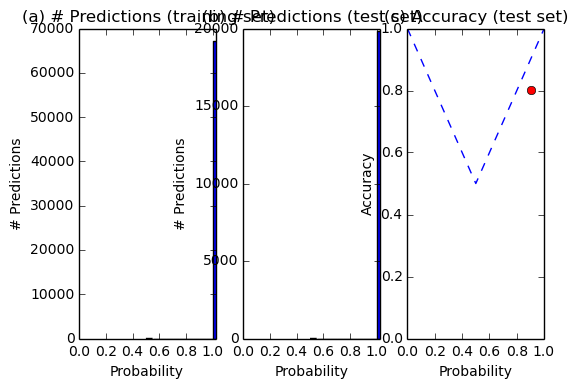

Recall-corrected Noise-aware Model
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Corpus Precision 0.803
Corpus Recall    1.0
Corpus F1        0.891
----------------------------------------
TP: 15932 | FP: 3914 | TN: 0 | FN: 0

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.5
Neg. class accuracy: 0.0
Corpus Precision 0.803
Corpus Recall    0.5
Corpus F1        0.616
----------------------------------------
TP: 15932 | FP: 3914 | TN: 0 | FN: 15932



In [35]:
tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [36]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, ATTRIBUTE)

Scoring on Entity-Level Gold Data
Corpus Precision 0.841
Corpus Recall    0.717
Corpus F1        0.774
----------------------------------------
TP: 665 | FP: 126 | FN: 262



In [37]:
from hardware_utils import separate_fns

unfound, misclassified = separate_fns(FN, cfn)
pprint(misclassified)

262 fns
92 unfound
170 misclassified
set([('112823', 'BC546BG', 'NPN'),
     ('112823', 'BC546BRL1G', 'NPN'),
     ('112823', 'BC546BZL1G', 'NPN'),
     ('112823', 'BC547ARLG', 'NPN'),
     ('112823', 'BC547AZL1G', 'NPN'),
     ('112823', 'BC547BG', 'NPN'),
     ('112823', 'BC547BRL1G', 'NPN'),
     ('112823', 'BC547BZL1G', 'NPN'),
     ('112823', 'BC547CG', 'NPN'),
     ('112823', 'BC547CZL1G', 'NPN'),
     ('112823', 'BC548BG', 'NPN'),
     ('112823', 'BC548BRL1G', 'NPN'),
     ('112823', 'BC548BZL1G', 'NPN'),
     ('112823', 'BC548CG', 'NPN'),
     ('112823', 'BC548CZL1G', 'NPN'),
     ('BC337', 'BC337-16', 'NPN'),
     ('BC337', 'BC337-25', 'NPN'),
     ('BC337', 'BC337-40', 'NPN'),
     ('BC337', 'BC338-25', 'NPN'),
     ('BC546-D', 'BC546BG', 'NPN'),
     ('BC546-D', 'BC546BRL1G', 'NPN'),
     ('BC546-D', 'BC546BZL1G', 'NPN'),
     ('BC546-D', 'BC547ARLG', 'NPN'),
     ('BC546-D', 'BC547AZL1G', 'NPN'),
     ('BC546-D', 'BC547BG', 'NPN'),
     ('BC546-D', 'BC547BRL1G', 'NPN'),
   

In [38]:
from pprint import pprint
pprint(FP)

[(u'BC337', u'BC33716', u'NPN'),
 (u'BC337', u'BC33725', u'NPN'),
 (u'BC337', u'BC33740', u'NPN'),
 (u'BC337', u'BC33740BU', u'NPN'),
 (u'BC337', u'BC33825', u'NPN'),
 (u'BC546-BC548C(TO-92)', u'BC546-BC548C', u'NPN'),
 (u'BC547', u'BC548BU', u'NPN'),
 (u'BC818-40LT1-D', u'BC818-40LT1', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3576', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3672', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3700', u'PNP'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3701', u'PNP'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3798A', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3799A', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3829', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3946', u'PNP'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3947', u'PNP'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3962', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3963', u'NPN'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3964', u'NPN'),
 (u'C

In [39]:
from pprint import pprint
pprint(FN)

[('112823', 'BC546BG', 'NPN'),
 ('112823', 'BC546BRL1G', 'NPN'),
 ('112823', 'BC546BZL1G', 'NPN'),
 ('112823', 'BC547ARLG', 'NPN'),
 ('112823', 'BC547AZL1G', 'NPN'),
 ('112823', 'BC547BG', 'NPN'),
 ('112823', 'BC547BRL1G', 'NPN'),
 ('112823', 'BC547BZL1G', 'NPN'),
 ('112823', 'BC547CG', 'NPN'),
 ('112823', 'BC547CZL1G', 'NPN'),
 ('112823', 'BC548BG', 'NPN'),
 ('112823', 'BC548BRL1G', 'NPN'),
 ('112823', 'BC548BZL1G', 'NPN'),
 ('112823', 'BC548CG', 'NPN'),
 ('112823', 'BC548CZL1G', 'NPN'),
 ('BC337', 'BC337-16', 'NPN'),
 ('BC337', 'BC337-25', 'NPN'),
 ('BC337', 'BC337-40', 'NPN'),
 ('BC337', 'BC338-25', 'NPN'),
 ('BC546-D', 'BC546BG', 'NPN'),
 ('BC546-D', 'BC546BRL1G', 'NPN'),
 ('BC546-D', 'BC546BZL1G', 'NPN'),
 ('BC546-D', 'BC547ARLG', 'NPN'),
 ('BC546-D', 'BC547AZL1G', 'NPN'),
 ('BC546-D', 'BC547BG', 'NPN'),
 ('BC546-D', 'BC547BRL1G', 'NPN'),
 ('BC546-D', 'BC547BZL1G', 'NPN'),
 ('BC546-D', 'BC547CG', 'NPN'),
 ('BC546-D', 'BC547CZL1G', 'NPN'),
 ('BC546-D', 'BC548BG', 'NPN'),
 ('BC546-D

In [40]:
from pprint import pprint
pprint([(unicode(x[0]), x[1]) for x in disc_model.get_feature_weights(F_dev)[:100]])

[(u'CORE_e2_SPAN_TYPE_[EXPLICIT]', 3.2667769300335356),
 (u'CORE_e2_STARTS_WITH_CAPITAL', 3.2667769300335356),
 (u'CORE_e2_LENGTH_1', 3.2667769300335356),
 (u'STR_e1_TAG_p', 2.933699011836862),
 (u'CORE_e1_LENGTH_1', 2.807212130074842),
 (u'STR_e1_PARENT_TAG_td', 2.745219025096593),
 (u'TAB_e1_ROW_SPAN_[1]', 2.7307489799196194),
 (u'STR_e1_LAST_NODE', 2.729523433373055),
 (u'TAB_e1_COL_SPAN_[1]', 2.7139426309643926),
 (u'CORE_e1_SPAN_TYPE_[EXPLICIT]', 2.7124267611010784),
 (u'DDL_e1_POS_SEQ_[NN]', 2.701705748914759),
 (u'DDL_e1_W_LEFT_POS_1_[NN]', 2.6208968415927796),
 (u'STR_e1_FIRST_NODE', 2.5383048261731687),
 (u'VIZ_e2_PAGE_[1]', 2.520335361523529),
 (u'DDL_e2_W_LEFT_POS_1_[NN]', 2.479608885372566),
 (u'STR_e1_ANCESTOR_TAG_[html body table tr td p]', 2.4496578078238924),
 (u'STR_e1_ANCESTOR_ID_[None None None None None None]', 2.4496578078238924),
 (u'DDL_e2_DEP_SEQ_[compound]', 2.380584668791523),
 (u'VIZ_e1_PAGE_[1]', 2.349741604095509),
 (u'STR_e2_TAG_p', 2.3214039302864076),
 (

In [41]:
from hardware_utils import entity_to_candidates

entity = FP[0]
print entity
print

matches = entity_to_candidates(entity, fp)
print "# Matches: %d" % len(matches)
print

candidate = matches[0]
print candidate
print

# throttler = get_part_throttler()
# print throttler(candidate)
# print disc_model.get_candidate_score(candidate, F_dev)
# print
# pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

(u'BC337', u'BC33716', u'NPN')

# Matches: 18

Part_Attr(Span("BC33716", parent=1260562, chars=[0,6], words=[0,0]), Span("NPN", parent=1258357, chars=[14,16], words=[3,3]))



In [42]:
# from hardware_utils import part_error_analysis
# part_error_analysis(candidate)

In [43]:
# If necessary:
# import os
# os.system('cp snorkel.db snorkel.db\ final');